In [1]:
import sys, os
from pathlib import Path
ROOT = Path.cwd()
if ROOT.name.lower() == "notebooks":   # if notebook is in /notebooks
    ROOT = ROOT.parent

sys.path.insert(0, str(ROOT))
print("Project root on sys.path:", ROOT)

Project root on sys.path: C:\Users\saita\Yahoo Stock Forecasting


In [2]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from src.config import (
    MODEL_DIR,
    DATA_PATH,
    DATE_COL,
    TARGET_COL,
    LSTM_HIDDEN_SIZE,
    LSTM_NUM_LAYERS,
    LSTM_DROPOUT,
    LSTM_BATCH_SIZE,
    LSTM_LOOKBACK,
)
from src.models_lstm import LSTMRegressor
from src.metrics import rmse, mae, mape, r2
from src.data_utils import inverse_transform_target, load_raw_data, train_val_test_split_time
import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_pred_vs_true(dates, y_true, y_pred, title: str):
    plt.figure(figsize=(12, 5))
    plt.plot(dates, y_true, label="True")
    plt.plot(dates, y_pred, label="Predicted")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Close")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
data = np.load("lstm_data.npz")

X_test = data["X_test"]         # (N_test_seq, seq_len, num_features)
y_test_scaled = data["y_test"]  # (N_test_seq, 1)

print("X_test:", X_test.shape)
print("y_test_scaled:", y_test_scaled.shape)

with open("scalers.pkl", "rb") as f:
    scalers = pickle.load(f)

target_scaler = scalers["target"]
num_features = X_test.shape[-1]
seq_len = X_test.shape[1]

print("Sequence length:", seq_len, "| Num features:", num_features)

X_test: (215, 60, 6)
y_test_scaled: (215, 1)
Sequence length: 60 | Num features: 6


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

test_ds = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test_scaled, dtype=torch.float32),
)
test_dl = DataLoader(test_ds, batch_size=LSTM_BATCH_SIZE, shuffle=False)

Using device: cpu


In [6]:
model = LSTMRegressor(
    num_features=num_features,
    hidden_size=LSTM_HIDDEN_SIZE,
    num_layers=LSTM_NUM_LAYERS,
    dropout=LSTM_DROPOUT,
).to(device)

ckpt_path = os.path.join(MODEL_DIR, "lstm_model.pth")
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

print("Loaded LSTM model from:", ckpt_path)

Loaded LSTM model from: C:\Users\saita\Yahoo Stock Forecasting\models\lstm_model.pth


In [7]:
y_true_scaled_list = []
y_pred_scaled_list = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        y_pred_scaled_list.append(preds)
        y_true_scaled_list.append(yb.numpy())

y_true_scaled = np.vstack(y_true_scaled_list).reshape(-1)
y_pred_scaled = np.vstack(y_pred_scaled_list).reshape(-1)

print("Scaled shapes -> y_true:", y_true_scaled.shape, "| y_pred:", y_pred_scaled.shape)

Scaled shapes -> y_true: (215,) | y_pred: (215,)


In [8]:
y_true = inverse_transform_target(y_true_scaled, target_scaler)
y_pred = inverse_transform_target(y_pred_scaled, target_scaler)

print("Real value shapes -> y_true:", y_true.shape, "| y_pred:", y_pred.shape)

Real value shapes -> y_true: (215,) | y_pred: (215,)


In [9]:
df_full = load_raw_data(DATA_PATH)
_, _, test_df = train_val_test_split_time(df_full)

# first available target after creating sequences with LOOKBACK
dates = test_df[DATE_COL].iloc[LSTM_LOOKBACK:].values

print("Number of dates:", len(dates))
print("y_true length  :", len(y_true))

assert len(dates) == len(y_true), "Date length and test length do not match!"

print("LSTM Test RMSE:", rmse(y_true, y_pred))
print("LSTM Test MAE :", mae(y_true, y_pred))
print("LSTM Test MAPE:", mape(y_true, y_pred))
print("LSTM Test R2  :", r2(y_true, y_pred))

Number of dates: 215
y_true length  : 215
LSTM Test RMSE: 109.67124167255517
LSTM Test MAE : 87.99396514892578
LSTM Test MAPE: 2.6319442
LSTM Test R2  : 0.7461960315704346


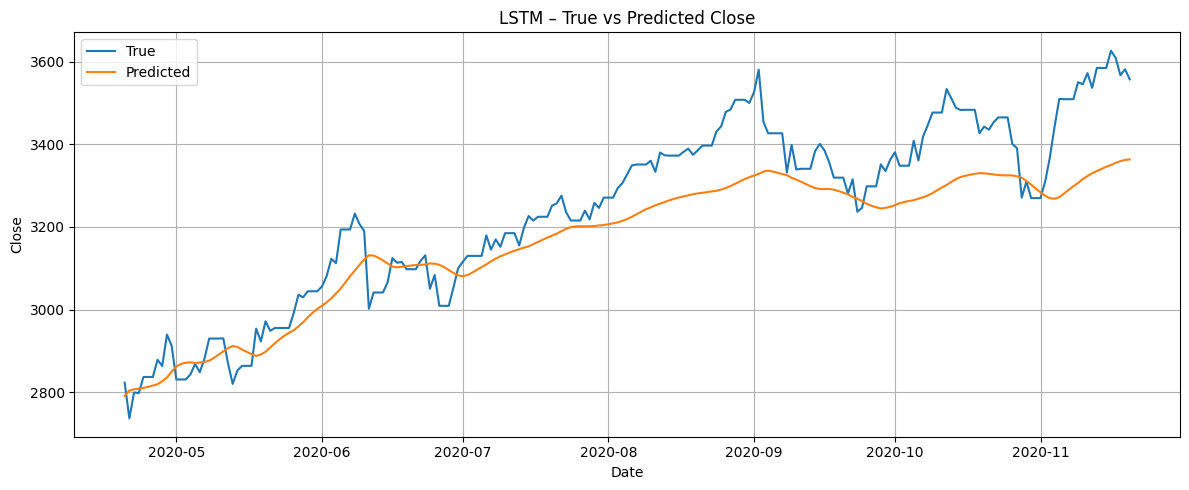

In [10]:
plot_pred_vs_true(dates, y_true, y_pred, "LSTM – True vs Predicted Close")